In [91]:
#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn import datasets, linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error


In [2]:
#Read data file
train_df = pd.read_csv('final_df.csv')
train_df.drop(columns = 'Unnamed: 0', inplace=True)
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


Getting data ready for Modeling
- (optional) Drop id fields
- One-hot encode all categorical values
- Standardize continous variables
- (optional) Create new features

## One-hot encoding categorical variables

In [3]:
# One-hot encode

# categorical_columns = ['category', 'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']
categorical_columns = ['category', 'cuisine', 'region_code', 'center_type']

# one_hot = pd.get_dummies(train_df['cuisine'], prefix='cuisine', prefix_sep='_', dtype=int)
# train_df = pd.concat([train_df, one_hot], axis=1)
one_hot_columns = [train_df]
for col in categorical_columns:
    one_hot = pd.get_dummies(train_df[col], prefix=col, prefix_sep='_', dtype=int)
    one_hot_columns.append(one_hot)


X_with_categorical = pd.concat(one_hot_columns, axis=1)

X_with_categorical


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,...,0,0,1,0,0,0,0,0,0,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,0,0,1,0,0,0,0,0,0,1
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,...,0,0,1,0,0,0,0,0,0,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,...,0,0,1,0,0,0,0,0,0,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,0,0,0,0,1,0,0,1,0,0
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,0,0,0,0,1,0,0,1,0,0
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,0,0,0,0,1,0,0,1,0,0
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,0,0,0,0,1,0,0,1,0,0


In [4]:
# ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
#        'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
#        'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']
numerical_columns = ['week', 'checkout_price', 'base_price']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

x_scaled = scaler.fit_transform(train_df[numerical_columns])
standardized_features = pd.DataFrame(x_scaled, columns=[f"{x}_std" for x in numerical_columns])

X_with_numerical = pd.concat([X_with_categorical, standardized_features], axis=1)
# enhanced_df


# scaler = MinMaxScaler(clip=True)

# x_scaled = scaler.fit_transform(train_df[numerical_columns])
# standardized_features = pd.DataFrame(x_scaled, columns=[f"{x}_std" for x in numerical_columns])

# X_with_numerical = pd.concat([X_with_categorical, standardized_features], axis=1)


X_with_numerical

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,week_std,checkout_price_std,base_price_std
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,...,0,0,0,0,0,0,1,-1.776494,-1.277687,-1.256048
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,0,0,0,0,0,0,1,-1.776494,-1.277687,-1.358465
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,...,0,0,0,0,0,0,1,-1.776494,-1.290568,-1.358278
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,...,0,0,0,0,0,0,1,-1.776494,0.047477,0.518763
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,...,0,0,0,0,0,0,1,-1.776494,-0.580222,-0.694746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,0,1,0,0,1,0,0,1.691304,0.992883,0.808467
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,0,1,0,0,1,0,0,1.691304,0.979806,0.796023
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,0,1,0,0,1,0,0,1.691304,-0.618276,-0.205870
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,0,1,0,0,1,0,0,1.691304,-0.580222,-0.253968


['week', 'checkout_price', 'base_price']
week
count    4.565480e+05
mean     1.115583e-16
std      1.000001e+00
min     -1.776494e+00
25%     -8.613810e-01
50%      2.965036e-02
75%      8.725179e-01
max      1.691304e+00
Name: week_std, dtype: float64
checkout_price
count    4.565480e+05
mean     8.231157e-16
std      1.000001e+00
min     -2.152935e+00
25%     -6.753579e-01
50%     -2.315878e-01
75%      7.387956e-01
max      3.491779e+00
Name: checkout_price_std, dtype: float64
base_price
count    4.565480e+05
mean    -7.433690e-16
std      1.000001e+00
min     -1.859224e+00
25%     -6.885239e-01
50%     -2.718877e-01
75%      6.515440e-01
max      3.186454e+00
Name: base_price_std, dtype: float64


<Axes: >

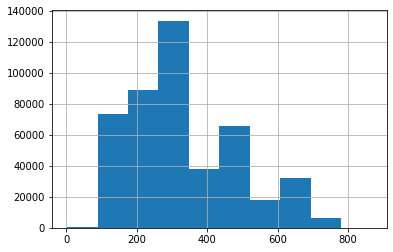

In [5]:
# Checking if outliers in numerical features

print(numerical_columns)

for col in numerical_columns:
    print(col)
    print(X_with_numerical[f'{col}_std'].describe())

X_with_numerical[f'checkout_price'].hist()

#### Drop unwanted columns

In [9]:
drop_columns = ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']

X = X_with_numerical.drop(drop_columns, axis=1)


In [ ]:
X.corr()

<Axes: >

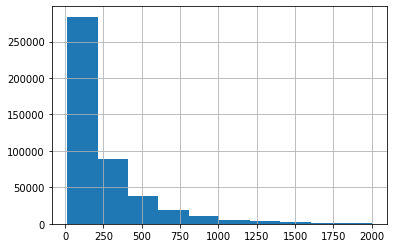

In [42]:
#Distribution of target variable
y[y<2000].hist()

In [11]:
y = X['num_orders']
X = X.drop('num_orders', axis=1)


#### Final dataset

In [12]:
X

,emailer_for_promotion,homepage_featured,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,...,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,week_std,checkout_price_std,base_price_std
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1.776494,-1.277687,-1.256048
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1.776494,-1.277687,-1.358465
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1.776494,-1.290568,-1.358278
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1.776494,0.047477,0.518763
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1.776494,-0.580222,-0.694746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1.691304,0.992883,0.808467
456544,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1.691304,0.979806,0.796023
456545,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1.691304,-0.618276,-0.205870
456546,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1.691304,-0.580222,-0.253968


Data is ready now!

## Linear Regression Model

In [13]:
# Split the data into training/testing sets
N = X.shape[0]

split_index = int(0.8*N)

X_train = X[:split_index]
X_test = X[split_index:]

# Split the targets into training/testing sets
y_train = y[:split_index]
y_test = y[split_index:]

print("Train size = ", X_train.shape)
print("Test size = ", X_test.shape)
print("Train size = ", y_train.shape)
print("Test size = ", y_test.shape)

Train size =  (365238, 34)
Test size =  (91310, 34)
Train size =  (365238,)
Test size =  (91310,)


In [14]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)


LinearRegression()

In [15]:

# Make predictions using the testing set
y_pred = regr.predict(X_test)


In [ ]:
for a,b in zip(y_pred, y_test):
    # print(item)
    if (a<0):
        print(a,b)

y_pred = [max(i, 0) for i in y_pred]

In [16]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))


Coefficients: 
 [ 2.50987038e+02  2.51845479e+02 -2.96016689e+12 -2.96016689e+12
 -2.96016689e+12 -2.96016689e+12 -2.96016689e+12 -2.96016689e+12
 -2.96016689e+12 -2.96016689e+12 -2.96016689e+12 -2.96016689e+12
 -2.96016689e+12 -2.96016689e+12 -2.96016689e+12 -2.96016689e+12
 -3.84517254e+12 -3.84517254e+12 -3.84517254e+12 -3.84517254e+12
  2.48570623e+12  2.48570623e+12  2.48570623e+12  2.48570623e+12
  2.48570623e+12  2.48570623e+12  2.48570623e+12  2.48570623e+12
 -3.75372097e+12 -3.75372097e+12 -3.75372097e+12 -4.75772729e+00
 -1.13976923e+02  2.51869412e+01]
Mean squared error: 79285.42
Coefficient of determination: 0.41


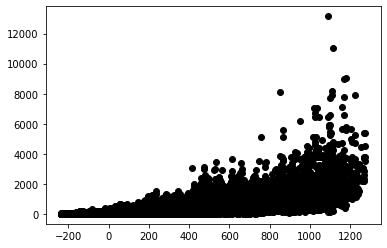

In [17]:
# Plot outputs
plt.scatter(y_pred, y_test, color="black")
plt.show()

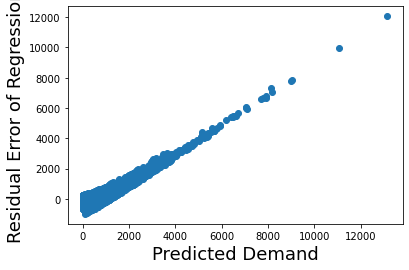

In [19]:
#Testing assumption about independent residual error.
res_error = y_test - y_pred
plt.xlabel('Predicted Demand', fontsize=18)
plt.ylabel('Residual Error of Regression', fontsize=18)
plt.scatter(y_test, res_error)
plt.show()

/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/546081090.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/546081090.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_series, shade=True, label="Predicted")


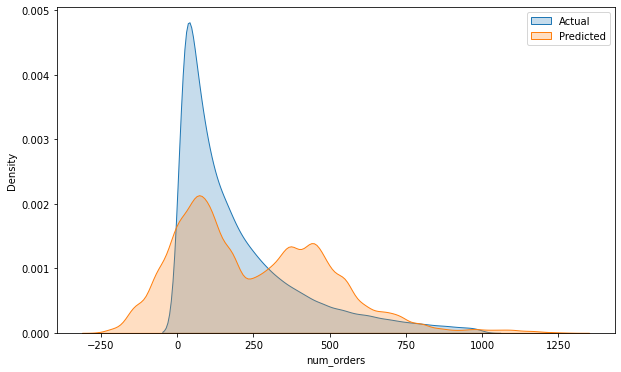

In [51]:
y_test[y_test<1000]
y_pred_series = pd.Series(y_pred)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
sns.kdeplot(y_pred_series, shade=True, label="Predicted")
plt.legend()
plt.show()


In [20]:
# Clear linear pattern in residuals. LR will not work out. 
#Will try GLM with poisson distribution.

## GLM with Poisson

In [34]:
# Fit the GLM with a log link function
glm_model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=sm.families.links.log()))
glm_results = glm_model.fit()

# Print the summary of the model
print(glm_results.summary())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_orders   No. Observations:               365238
Model:                            GLM   Df Residuals:                   365207
Model Family:                 Poisson   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0957e+07
Date:                Tue, 07 May 2024   Deviance:                   3.9459e+07
Time:                        16:29:28   Pearson chi2:                 4.60e+07
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
emailer_for_promotion     0.44

In [35]:
# Make predictions using the testing set
y_pred_glm = glm_results.predict(X_test)

In [36]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_glm))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_glm))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))

Mean squared error: 59038.38
Coefficient of determination: 0.56


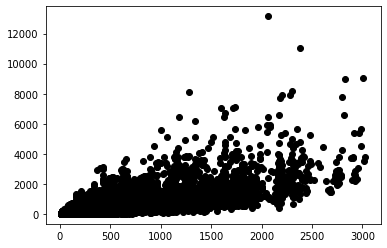

In [37]:
# Plot outputs
plt.scatter(y_pred_glm, y_test, color="black")
plt.show()

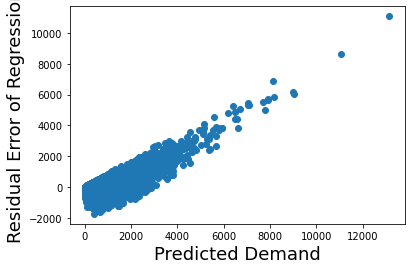

In [38]:
#Testing assumption about independent residual error.
res_error_glm = y_test - y_pred_glm
plt.xlabel('Predicted Demand', fontsize=18)
plt.ylabel('Residual Error of Regression', fontsize=18)
plt.scatter(y_test, res_error_glm)
plt.show()

/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/3093560113.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/3093560113.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_glm_series, shade=True, label="Predicted")


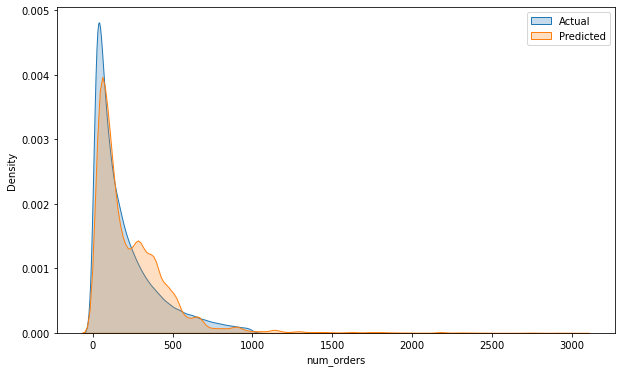

In [53]:
y_test[y_test<1000]
y_pred_glm_series = pd.Series(y_pred_glm)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
sns.kdeplot(y_pred_glm_series, shade=True, label="Predicted")
plt.legend()
plt.show()

In [ ]:
# Poisson GLM predicts the probability distribution better than LR.
# There is some noise around values 250 - 500

## Naive Bayes

In [54]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [57]:
y_pred_nb = nb_model.predict(X_test)

In [58]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_nb))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_nb))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))

Mean squared error: 4618185.75
Coefficient of determination: -33.47


/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/658252345.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/658252345.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_nb_series, shade=True, label="Predicted")


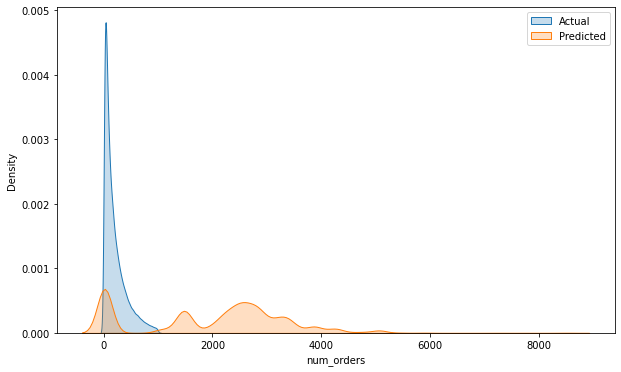

In [59]:
y_test[y_test<1000]
y_pred_nb_series = pd.Series(y_pred_nb)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
sns.kdeplot(y_pred_nb_series, shade=True, label="Predicted")
plt.legend()
plt.show()

In [60]:
# NaiveBayes is used for classification ideally.
# This was just a random experiment to observe how bad the model performs.

In [62]:
X_train.shape

(365238, 34)

# Decision Tree

In [93]:
dt_model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, 25, 50, 75, 100],
}
# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


In [68]:
print(best_params)

{'max_depth': 10}


In [94]:
y_pred_dt = best_estimator.predict(X_test)


In [66]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_dt))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_dt))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))

Mean squared error: 65025.62
Coefficient of determination: 0.51


 99%|===================| 360350/365238 [00:37<00:00]        

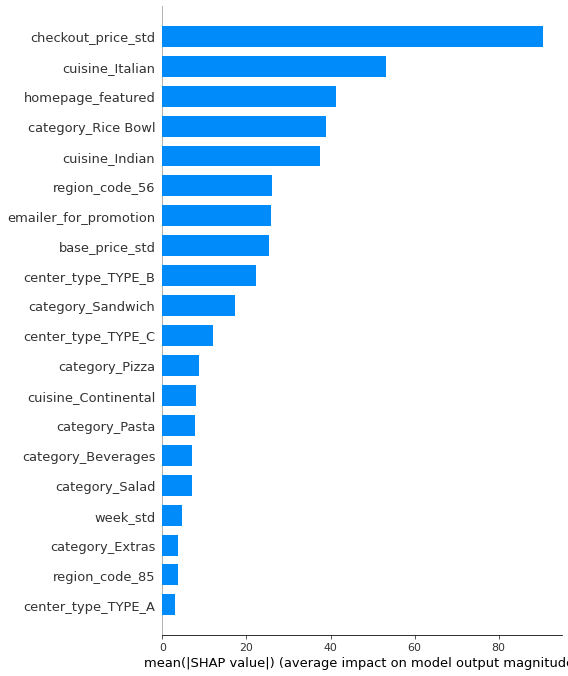

In [95]:
# Initialize the SHAP explainer with the fitted model
explainer = shap.Explainer(best_estimator, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
# The co-effecient of determination is lower than GLM - Poisson

# Random Forest

In [74]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [500],  # Number of trees in the forest
    'max_depth': [10],    # Maximum depth of each tree
    # 'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 10, 'n_estimators': 500}


In [75]:

# Make predictions on the testing data using the best estimator
y_pred_rf = best_estimator.predict(X_test)

In [77]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_rf))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))

Mean squared error: 59857.19
Coefficient of determination: 0.55


/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/4239066890.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/4239066890.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_rf_series, shade=True, label="Predicted")


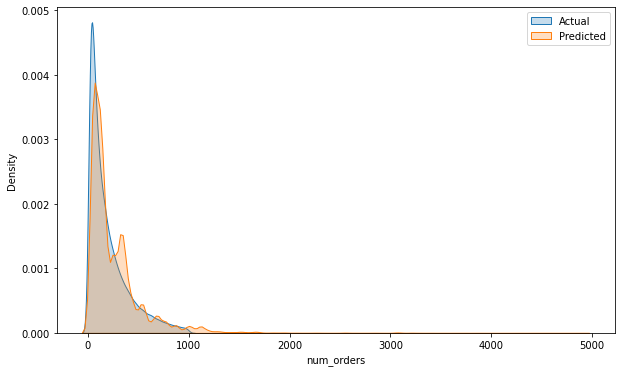

In [78]:
y_test[y_test<1000]
y_pred_rf_series = pd.Series(y_pred_rf)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
sns.kdeplot(y_pred_rf_series, shade=True, label="Predicted")
plt.legend()
plt.show()

# XGBoost 

In [84]:
# Convert the training and testing data into DMatrix format (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eval_metric': 'rmse',             # Root Mean Squared Error as evaluation metric
    'eta': 0.1,                        # Learning rate (step size shrinkage)
    'max_depth': 6,                    # Maximum depth of a tree
    'min_child_weight': 1,             # Minimum sum of instance weight (Hessian) needed in a child
    'subsample': 0.8,                  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,           # Subsample ratio of columns when constructing each tree
    'gamma': 0.1,                      # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': 1,                       # L2 regularization term on weights
    'alpha': 0                         # L1 regularization term on weights
}

# Train the XGBoost model
num_round = 1000  # Number of boosting rounds
xgb_model = xgb.train(params, dtrain, num_round)

In [85]:
# Make predictions on the testing data
y_pred_xgb = xgb_model.predict(dtest)

In [86]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_xgb))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_xgb))
# print("MSLE: %.2f" % mean_squared_log_error(y_test, y_pred))

Mean squared error: 59122.13
Coefficient of determination: 0.56


/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/682550918.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
/var/folders/8w/zhgft4yx2t11pqn824c8tfc80000gp/T/ipykernel_14993/682550918.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_xgb_series, shade=True, label="Predicted")


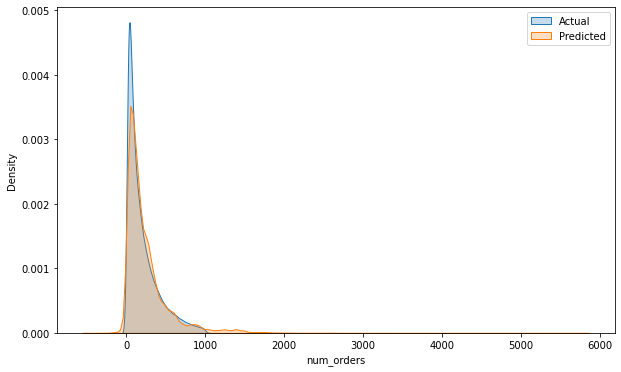

In [87]:
y_test[y_test<1000]
y_pred_xgb_series = pd.Series(y_pred_xgb)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[y_test<1000], shade=True, label="Actual")
sns.kdeplot(y_pred_xgb_series, shade=True, label="Predicted")
plt.legend()
plt.show()

In [88]:
# xgb is performing good across the 250 to 500 section

In [51]:
# Idea for later
# user is browsing on particular Shop
# predict - final basket value
# user, product, impression/click, basket value

# Regression model
# Shop 1 - selling gloves and socks (5$- 25$)
# Shop 2 - selling branded stuff (200$ - 300$)

# avg_order_value (per_shop)


#  avg_order_value (per_shop) * prediction --> final value

### Debugging section

In [111]:
# Checking if outliers in numerical features

print(numerical_columns)

for col in numerical_columns:
    print(col)
    print(X[f'{col}_std'].describe())

['week', 'checkout_price', 'base_price']
week
count    456548.000000
mean          0.512283
std           0.288368
min           0.000000
25%           0.263889
50%           0.520833
75%           0.763889
max           1.000000
Name: week_std, dtype: float64
checkout_price
count    456548.000000
mean          0.381407
std           0.177157
min           0.000000
25%           0.261763
50%           0.340380
75%           0.512290
max           1.000000
Name: checkout_price_std, dtype: float64
base_price
count    456548.000000
mean          0.368479
std           0.198190
min           0.000000
25%           0.232020
50%           0.314593
75%           0.497608
max           1.000000
Name: base_price_std, dtype: float64
